In [9]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import utils
import matplotlib.pyplot as plt
import seaborn as sns
import operator


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
model_name = 'enformer'
data_dir = '../data/'
pdf_dir = utils.make_dir('pdfs/distance_test/')


In [4]:
tile_coords = pd.read_csv(f'../results/summary_csvs/enformer/sufficiency_test_tile_coordinates.csv', index_col='Unnamed: 0').T
tss_tile = tile_coords.loc['tss'].T.values
cre_tile_coords = tile_coords.loc[[t for t in tile_coords.index if 'tss' not in t]]
cre_tiles_starts = cre_tile_coords[0].values
cre_tiles_starts_abs = np.abs(cre_tiles_starts - tss_tile[0]) // 1000
cre_df = pd.read_csv(f'../results/summary_csvs/enformer/sufficient_CREs.csv')
cre_df['tile start relative to tss'] =  np.abs(cre_df['tile_start'] - tss_tile[0]) // 1000


In [5]:
cre_df.groupby(['cell_line', 'context', 'tile class']).count()['seq_id']

cell_line  context    tile class
GM12878    enhancing  Enhancer       41
           silencing  Silencer       57
K562       enhancing  Enhancer       74
           silencing  Silencer      222
PC-3       enhancing  Enhancer       35
           silencing  Silencer       97
Name: seq_id, dtype: int64

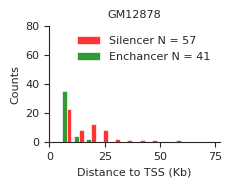

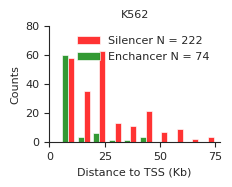

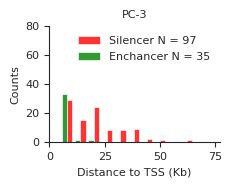

In [10]:
fontsize=8
#sns.set(font_scale = 1.3)
sns.set_style(style='white')
#plt.rcParams['xtick.major.size'] = 5
#plt.rcParams['xtick.major.width'] = 1
#plt.rcParams['ytick.major.size'] = 5
#plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
color_map = {'Silencer': 'r', 'Enhancer': 'g'}
for cell, df in cre_df.groupby('cell_line'):
    fig, ax = plt.subplots(1, 1, figsize=[2.2,1.5])
    N = ({r[0]: r[1] for _,r in df.groupby('tile class').count().iloc[:,1].reset_index().iterrows()})
    sns.histplot(data=df, x='tile start relative to tss', hue='tile class', multiple="dodge", shrink=.8, ax=ax,bins=10, palette=color_map, alpha=0.8)
    ax.set_yticks([0, 20, 40, 60, 80])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xticks([0,25,50,75], fontsize=fontsize)
    ax.set_xlabel('Distance to TSS (Kb)', fontsize=fontsize)
    ax.set_ylabel('Counts', fontsize=fontsize)
    ax.set_xlim(0,77)

    
    plt.legend([f'Silencer N = {N["Silencer"]}', f'Enchancer N = {N["Enhancer"]}'], frameon=False, fontsize=8)
    plt.title(cell, fontsize=fontsize)
    plt.savefig(f"{pdf_dir}/frequency_vs_distance_{cell}.pdf", bbox_inches='tight')
    plt.show()

In [11]:
result_normalized_effects

,Unnamed: 0,Fold change over control,CRE sufficiency effect,Binned distance (Kb),Normalized CRE effect (control),cell line,control,enf_data_id,context,tile class
0,0,0.010778,0.002732,95.0,0.604941,PC-3,0.393413,NUP85_chr17_75205706_+_100804_105804,enhancing,Enhancer
1,1,0.008779,0.001615,90.0,0.604941,PC-3,0.393413,NUP85_chr17_75205706_+_100804_105804,enhancing,Enhancer
2,2,0.008277,0.001335,85.0,0.604941,PC-3,0.393413,NUP85_chr17_75205706_+_100804_105804,enhancing,Enhancer
3,3,0.009459,0.001995,80.0,0.604941,PC-3,0.393413,NUP85_chr17_75205706_+_100804_105804,enhancing,Enhancer
4,4,0.011132,0.002930,75.0,0.604941,PC-3,0.393413,NUP85_chr17_75205706_+_100804_105804,enhancing,Enhancer
...,...,...,...,...,...,...,...,...,...,...
19983,33,0.737043,-0.273697,75.0,-0.345831,K562,92.271970,ZNF93_chr19_19900945_+_75804_80804,silencing,Silencer
19984,34,0.725704,-0.284870,80.0,-0.345831,K562,92.271970,ZNF93_chr19_19900945_+_75804_80804,silencing,Silencer
19985,35,0.783196,-0.228216,85.0,-0.345831,K562,92.271970,ZNF93_chr19_19900945_+_75804_80804,silencing,Silencer
19986,36,0.848512,-0.163851,90.0,-0.345831,K562,92.271970,ZNF93_chr19_19900945_+_75804_80804,silencing,Silencer


In [16]:
sorted_dfs = []
result_normalized_effects = pd.read_csv("../results/summary_csvs/enformer/distance_test.csv")

x_axis = np.concatenate([-(result_normalized_effects['Binned distance (Kb)'].unique()),
                        result_normalized_effects['Binned distance (Kb)'].unique()[::-1]])
for (s, cell), df in result_normalized_effects.groupby(['enf_data_id', 'cell line']):
    pointers = np.arange(df.shape[0])
    tile_class = df['tile class'].values[0]
    cre_effect = df['CRE sufficiency effect'].values
    relative_effect = df['Fold change over control'].values
    half_window = pointers.shape[0] // 2
    left_side = pointers[:half_window]
    right_side = pointers[half_window:]
    if 'Enhancer' in tile_class:
        compare = operator.gt
    else:
        compare = operator.lt # strong = what leads to biggest drop in silencers

    if compare(np.mean(cre_effect[left_side]), np.mean(cre_effect[right_side])):
        strong_eff = cre_effect[left_side][::-1] # flip the left side
        weak_eff = cre_effect[right_side]

        strong_rel_eff = relative_effect[left_side][::-1]
        weak_rel_eff = relative_effect[right_side]
        

    else:
        strong_eff = cre_effect[right_side]
        weak_eff = cre_effect[left_side]
        strong_rel_eff = relative_effect[right_side]
        weak_rel_eff = relative_effect[left_side]


    sorted_df = pd.DataFrame([np.concatenate([weak_eff, strong_eff]), np.concatenate([weak_rel_eff, strong_rel_eff])]).T
    
    sorted_df.columns = ['CRE sufficiency effect', 'Fold change over control']
    sorted_df['seq_id'] = s
    sorted_df['cell line'] = cell
    sorted_df['tile class'] = tile_class
    sorted_df['Binned distance (Kb)'] = x_axis
    sorted_dfs.append(sorted_df)

sorted_dfs = pd.concat(sorted_dfs)

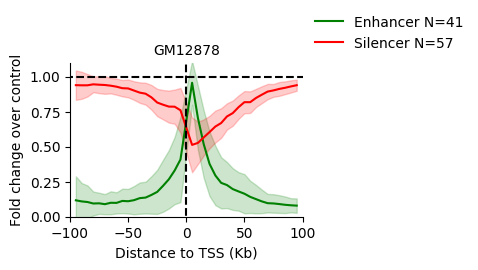

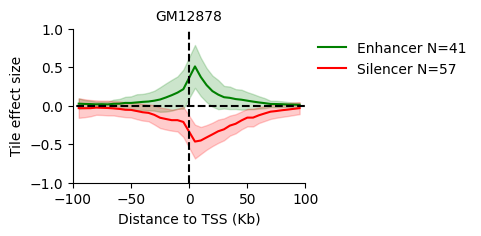

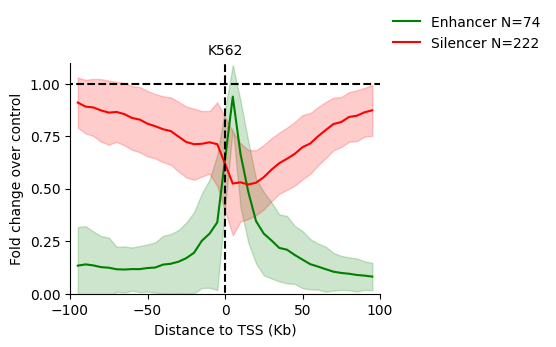

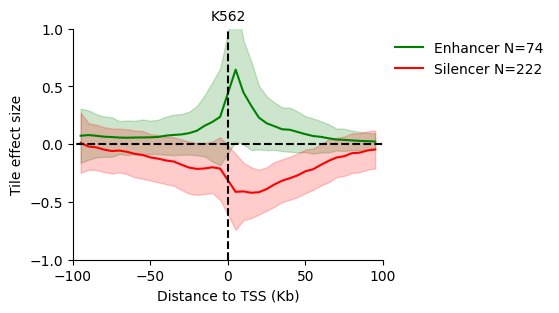

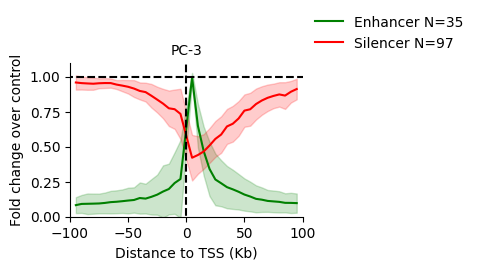

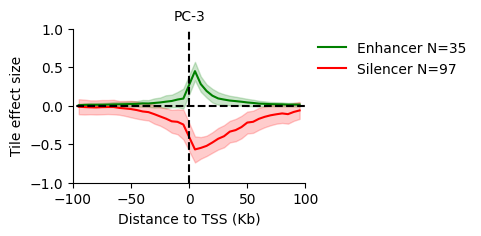

In [53]:
fontsize = 10
for cell_line, df in sorted_dfs.groupby('cell line'):
    n_df = df.groupby(['tile class']).count()
    n_dict = dict(zip(list(n_df.index), n_df.iloc[:,-1]))
    my_palette = {}
    tile_labels = {}
    for i, row in n_df.iterrows():
        c = 'g' if i=='Enhancer' else 'r'
        my_palette[f'{i} N={row.iloc[0]//38}'] = c
        k = 'Enhancer' if 'Enh' in i else 'Silencer'
        tile_labels[k] = f'{i} N={row.iloc[0]//38}'
    df['tile class'] = [tile_labels[t] for t in df['tile class']]
    for y, hline_y, filename_label in [['Fold change over control', 1, 'fold_change'], ["CRE sufficiency effect", 0, 'cre_effect']]:
        if cell_line == 'K562':
            fig, ax = plt.subplots(1, figsize=[4, 3])
        else:
            fig, ax = plt.subplots(1, figsize=[3, 2])

        sns.lineplot(data=df, x='Binned distance (Kb)', y=y, hue='tile class', #ci='sd',
                  palette=my_palette, ax=ax, errorbar='sd')
        ax.plot([-250, 250],[hline_y, hline_y], '--k')
        ax.plot([0, 0],[-1, 2], '--k')
        ax.set_xlim([-100, 100])



        # ax.set_ylim(0,1.75)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.setp(ax.get_xticklabels(), fontsize=fontsize)
        plt.setp(ax.get_yticklabels(), fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        # ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

        # plt.xticks([0,25,50,75], fontsize=fontsize)
        ax.set_xlabel('Distance to TSS (Kb)', fontsize=fontsize)
        ax.set_title(cell_line, fontsize=fontsize)
        if y == "CRE sufficiency effect":
            ax.set_ylabel('Tile effect size', fontsize=fontsize)
            ax.set_ylim(-1,1)
            ax.set_yticks([-1, -0.5, 0, 0.5, 1])


        else:
            ax.set_ylabel(y, fontsize=fontsize)
            ax.set_ylim(0,1.1)
            ax.set_yticks([0, 0.25, 0.5, 0.75, 1])



    
        plt.legend(frameon=False, bbox_to_anchor=[1,1], fontsize=fontsize)
        plt.savefig(f"{pdf_dir}/distance_test_{filename_label}_{cell_line}.pdf", bbox_inches='tight')
        plt.show()